# The Rise-Contact involution on Interval-posets

The notebook shows some implementation related to [2] the original definition of Tamari Interval-posets ca be found in [1].
 
[1] Grégory Châtel and Viviane Pons. [Counting smaller elements in the Tamari and m-Tamari lattices](http://arxiv.org/abs/1311.3922), Journal of Combinatorial Theory, Series A, 134():58 – 97, 2015. 

[2] Viviane Pons. The Rise-Contact involution on Tamari Intervals



In [38]:
# utils: a function to show latex printed objects in the notebook
# useful to show objects on a Jupyter notebook
# on a local Sage instal, just use view(objects)
from sage.misc.latex import _Latex_prefs
from sage.misc.latex import png
import os
from IPython.display import Image
def viewLatex(objects):
    engine = _Latex_prefs._option["engine"]
    file_name = tmp_filename() + ".png"
    png(objects, file_name, debug = False, engine = engine)
    return Image(filename = file_name)

## Statistics

First let us see how to get the different statistics on Tamari intervals referenced in the paper.

The *number of contacts* and *initial rises* are already implemented for Dyck Paths.

In [39]:
dw = DyckWord([1,1,0,1,1,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0])

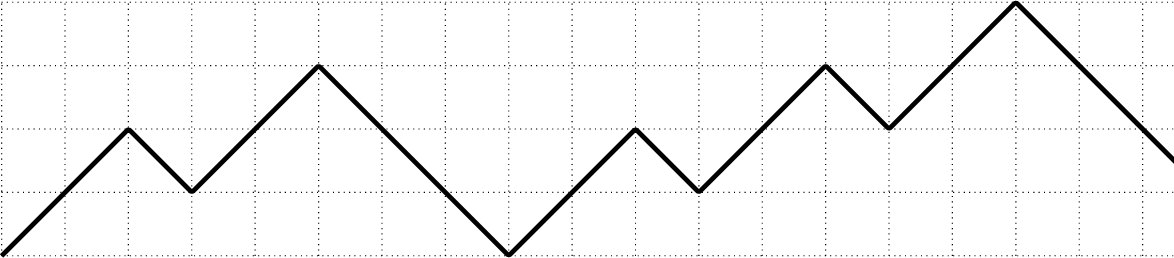

In [40]:
viewLatex(dw)

In [41]:
dw.number_of_touch_points()

2

In [42]:
dw.number_of_initial_rises()

2

In [43]:
def contact_vector(dw):
    x = 0
    y = 0
    vector = [dw.number_of_touch_points()]
    for i,step in enumerate(dw):
        if step == 1:
            y += 1
            d = y - x
            c = 0
            xx = x
            yy = y
            for k in xrange(i+1,len(dw)):
                dd = yy - xx
                if dd == d:
                    c+=1
                elif dd < d:
                    break
                xx, yy = (xx+1, yy) if dw[k] == 0 else (xx, yy+1)
            c -= 1
            vector.append(c)
            
        else:
            x += 1
    return vector[:-1]

In [44]:
contact_vector(dw)

[2, 2, 0, 1, 0, 2, 0, 2, 0, 1]

In [45]:
def rise_vector(dw):
    vector = []
    r = 0
    for step in dw:
        if step == 0:
            vector.append(r)
            r = 0
        else:
            r+=1
    return vector

In [46]:
rise_vector(dw)

[2, 2, 0, 0, 2, 2, 2, 0, 0, 0]

We represent the contact monomial and rise monomial as partitions: each occurrence of $i$ in the list represents an occurrence of $x_i$ (resp. $y_i$) in the monomial.

In [47]:
def contact_monomial(dw):
    v = contact_vector(dw)
    v.sort()
    v.reverse()
    return v

In [48]:
def rise_monomial(dw):
    v = rise_vector(dw)
    v.sort()
    v.reverse()
    return v

In [49]:
contact_monomial(dw)

[2, 2, 2, 2, 1, 1, 0, 0, 0, 0]

In [50]:
rise_monomial(dw)

[2, 2, 2, 2, 2, 0, 0, 0, 0, 0]

Here are the basic functions to get those statistics on interval-posets.

In [51]:
def contacts_interval(tip):
    return tip.lower_dyck_word().number_of_touch_points()

def rises_interval(tip):
    return tip.upper_dyck_word().number_of_initial_rises()

def contact_vector_interval(tip):
    return contact_vector(tip.lower_dyck_word())

def rise_vector_interval(tip):
    return rise_vector(tip.upper_dyck_word())

def contact_monomial_interval(tip):
    return contact_monomial(tip.lower_dyck_word())

def rise_monomial_interval(tip):
    return rise_monomial(tip.upper_dyck_word())

In [52]:
# The interval poset of Fig. 3
tip = TamariIntervalPoset(10, [(2,5), (3,4), (4,5), (6,7), (8,10), (9,10), (3,2), (4,2), (6,5), (7,5), (8,5), (10,5), (9,8)])

In [53]:
tip

The Tamari interval of size 10 induced by relations [(2, 5), (3, 4), (4, 5), (6, 7), (8, 10), (9, 10), (10, 5), (9, 8), (8, 5), (7, 5), (6, 5), (4, 2), (3, 2)]

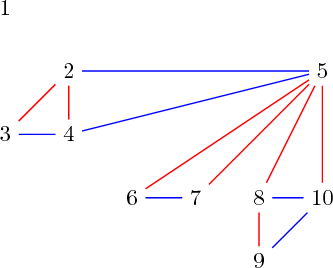

In [54]:
viewLatex(tip)

In [55]:
contacts_interval(tip)

3

In [56]:
rises_interval(tip)

3

In [57]:
contact_vector_interval(tip)

[3, 0, 2, 0, 0, 4, 0, 0, 1, 0]

In [58]:
rise_vector_interval(tip)

[3, 1, 0, 2, 3, 0, 1, 0, 0, 0]

In [59]:
contact_monomial_interval(tip)

[4, 3, 2, 1, 0, 0, 0, 0, 0, 0]

In [60]:
rise_monomial_interval(tip)

[3, 3, 2, 1, 1, 0, 0, 0, 0, 0]

The paper also defined the DC and IC vectors.

In [61]:
def dc(tip):
    L = [len(tip.decreasing_children(i)) for i in tip]
    return [len(tip.decreasing_roots())] + L[:-1]

def ic(tip):
    L = [len(tip.increasing_children(i)) for i in tip]
    L.reverse()
    return [len(tip.increasing_roots())] + L[:-1]

In [62]:
dc(tip)

[3, 0, 2, 0, 0, 4, 0, 0, 1, 0]

In [63]:
ic(tip)

[4, 2, 0, 0, 1, 0, 2, 1, 0, 0]

You can check that DC is similar to the contact vector.

In [64]:
all(dc(v) == contact_vector_interval(v) for v in TamariIntervalPosets(4))

True

The *distance* statistic can be computed directly on interval-posets by computing the number of Tamari inversions.

In [65]:
tip.number_of_tamari_inversions()

4

## Involutions

### Grafting Trees

The following functions gives the grafting-tree of an interval-poset and the inverse construction.

In [66]:
def decompose(tip):
    """
    Decompose an interval-poset into a triplet (left, right, r)
    
    Input:
        - tip, an interval poset
        
    Output: a triplet (left, right, r) where left and right are interval posets and r 
    is the parameter of the composition.
    """
    n = tip.size()
    if n == 0:
        return None
    root = tip.increasing_roots()[-1]
    r = len(tip.decreasing_children(root))
    left = tip.sub_poset(1,root)
    right = tip.sub_poset(root+1,tip.size()+1)
    return left, right, r

def recompose(left, right, r):
    """
    Recompose an interval-poset from a triplet (left, right, r)
    
    Input:
        - left, an interval-poset
        - right, an interval-poset
        - r, the parameter of the recomposition
        
    Output: an interval-poset
    """
    root = left.size() + 1
    rel = left.poset().cover_relations()
    rel.extend((i,root) for i in left)
    rel.extend((root+a,root+b) for a,b in right.poset().cover_relations())
    decroot = right.decreasing_roots()[:r]
    rel.extend((root+i,root) for i in decroot)
    return TamariIntervalPoset(left.size()+right.size()+1,rel)
    
def grafting_tree(tip):
    n = tip.size()
    if n == 0:
        return LabelledBinaryTree(None)
    left, right, r = decompose(tip)
    return LabelledBinaryTree([grafting_tree(left), grafting_tree(right)], label = r)

def interval_from_grafting_tree(tree):
    if tree.is_empty():
        return TamariIntervalPoset(0,[])
    r = tree.label()
    left = interval_from_grafting_tree(tree[0])
    right = interval_from_grafting_tree(tree[1])
    return recompose(left, right, r)

Here is the computation of the example of Fig. 19.

In [67]:
tip = TamariIntervalPoset(8, [(1,2), (2,4), (3,4), (6,7), (3,2), (5,4), (6,4), (8,7)])

In [68]:
decompose(tip)

(The Tamari interval of size 3 induced by relations [(1, 2), (3, 2)],
 The Tamari interval of size 4 induced by relations [(2, 3), (4, 3)],
 2)

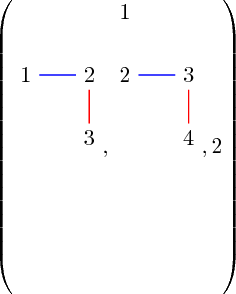

In [69]:
viewLatex(decompose(tip))

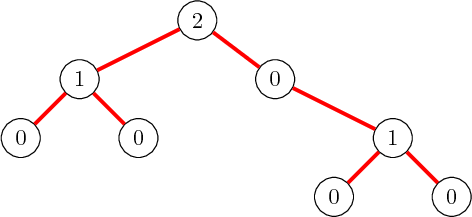

In [70]:
viewLatex(grafting_tree(tip))

In [71]:
t = grafting_tree(tip)
t

2[1[0[., .], 0[., .]], 0[., 1[0[., .], 0[., .]]]]

In [72]:
tip == interval_from_grafting_tree(t)

True

### Left branch involution

This allows us to implement very easily the left branch involution.

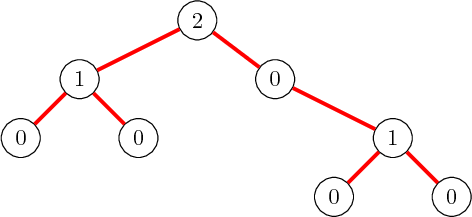

In [73]:
viewLatex(t)

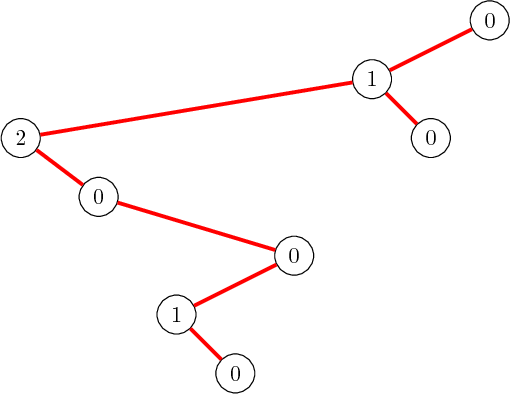

In [74]:
viewLatex(t.left_border_symmetry())

In [75]:
def left_branch_involution(tip):
    return interval_from_grafting_tree(grafting_tree(tip).left_border_symmetry())

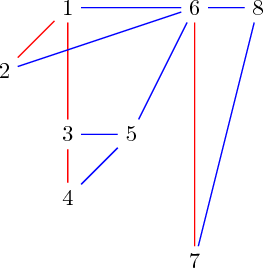

In [76]:
viewLatex(left_branch_involution(tip))

You can check that the left branch involution exchanges the IC vector and rise vector while keeping the contact monomial and distance.

In [77]:
def check_left_branch_involution_statistics(tip):
    image = left_branch_involution(tip)
    return rise_vector_interval(image) == ic(tip) \
    and contact_monomial_interval(image) == contact_monomial_interval(tip) \
    and image.number_of_tamari_inversions() == tip.number_of_tamari_inversions()

In [78]:
check_left_branch_involution_statistics(tip)

True

In [79]:
all(check_left_branch_involution_statistics(v) for v in TamariIntervalPosets(4))

True

### The Rise-contact involution

The complement involution is already implemented in Sage.

In [80]:
tip.complement()

The Tamari interval of size 8 induced by relations [(1, 2), (3, 5), (4, 5), (6, 7), (8, 7), (7, 5), (6, 5), (3, 2)]

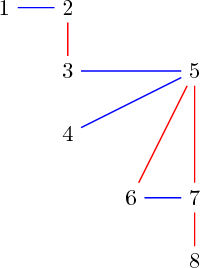

In [81]:
viewLatex(tip.complement())

This allows us to trivially implement the Rise-contact involution on interval-poset

In [82]:
def rise_contact_involution(tip):
    """
    The Rise-contact involution on interval-posets
    """
    return left_branch_involution(left_branch_involution(tip).complement())

def rise_contact_involution_grafting_tree(t):
    """
    The Rise-contact involution on a grafting tree
    """
    t = t.left_border_symmetry()
    tip = interval_from_grafting_tree(t).complement()
    return grafting_tree(tip).left_border_symmetry()


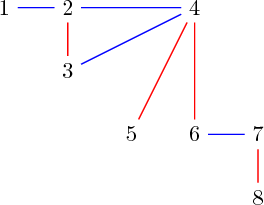

In [83]:
# the example of Fig. 22
tip = TamariIntervalPoset(8, [(1,2), (2,4), (3,4), (6,7), (3,2), (5,4), (6,4), (8,7)])
viewLatex(tip)

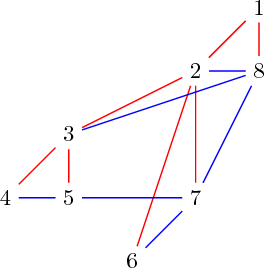

In [84]:
viewLatex(rise_contact_involution(tip))

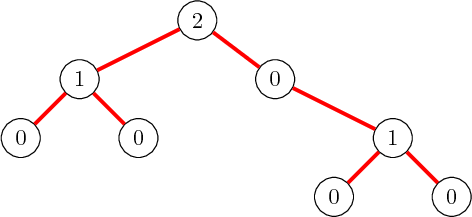

In [85]:
t = grafting_tree(tip)
viewLatex(t)

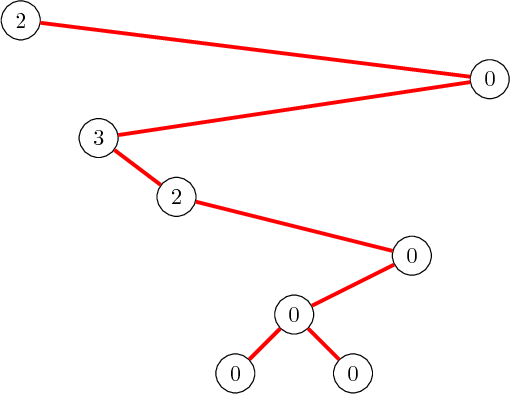

In [86]:
viewLatex(rise_contact_involution_grafting_tree(t))

**The following function allows you to compute the involution directly on an interval $[D_1, D_2]$ given by two Dyck paths** 

In [87]:
def rise_contact_involution_dyck_paths_interval(d1, d2):
    """
    The rise-contact involution on a interval of Tamari (d1, d2)
    INPUT:
        - d1, the lower bound Dyck path
        - d2, the upper bound Dyck Path
    OUTPUT : a tuple (d1',d2') of Dyck paths
    """
    tip = TamariIntervalPosets.from_dyck_words(d1,d2)
    image = rise_contact_involution(tip)
    return image.lower_dyck_word(), image.upper_dyck_word()

In [88]:
d1 = DyckWord([1,0,1,1,0,0,1,1,0,1,0,0,1,1,0,0])
d2 = DyckWord([1,0,1,1,0,0,1,1,1,0,1,1,0,0,0,0])
rise_contact_involution_dyck_paths_interval(d1, d2)

([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0])

Let's check that the involution has the wanted effect on statistics.

In [89]:
def check_rise_contact_statistics(tip):
    image = rise_contact_involution(tip)
    return contact_monomial_interval(image) == rise_monomial_interval(tip)\
    and contacts_interval(image) == rises_interval(tip) \
    and tip.number_of_tamari_inversions() == image.number_of_tamari_inversions()

In [90]:
check_rise_contact_statistics(tip)

True

In [91]:
all(check_rise_contact_statistics(v) for v in TamariIntervalPosets(4))

True

## $m$-Tamari intervals

### $m$-ballot paths, intervals and statistics

$m$-ballot paths are not natively implemented in sage, we represent them by a `tuple` of 0 and 1. The following functions implement the $m$-Tamari cover relations and allow to generate all intervals of the $m$-Tamari lattice.

In [92]:
def m_rotations(m, path):
    """
    A generator of the paths obtained by a Tamari rotation on `path`
    
    INPUT:
    
        - `m` an integer, the paramter of the m-Tamari lattice
        - `path` a m-ballot path
    """
    for i in xrange(len(path)-1):
        if path[i] == 0 and path[i+1] == 1:
            x,y = 0,0
            for j in xrange(i+1, len(path)):
                x,y = (x+1,y) if path[j] == 0 else (x,y+1)
                if x == m*y:
                    break
            yield path[:i] + path[i+1:j+1] + path[i:i+1] + path[j+1:]
            
def m_paths(m,n):
    """
    A generator for $m$-ballot paths
    """
    seed = ((1,) + (0,)*m)*n
    return RecursivelyEnumeratedSet([seed], lambda x: m_rotations(m, x))

def m_intervals(m, n):
    """
    A generator for intervals of $m$-Tamari lattice given as tuple of $m$-ballot paths
    """
    return RecursivelyEnumeratedSet([(p,p) for p in m_paths(m,n)], lambda (p1,p2): ((p1,pp2) for pp2 in m_rotations(m,p2)))

def mcatalan_number(m, n):
    return binomial((m+1)*n, n)/(m*n+1)

def number_of_mTamari_intervals(m,n):
    return binomial((m+1)**2*n+m, n-1) *(m+1)/(n*(m*n+1))

In [93]:
list(m_paths(2,2))

[(1, 0, 0, 1, 0, 0), (1, 0, 1, 0, 0, 0), (1, 1, 0, 0, 0, 0)]

In [94]:
list(m_intervals(2,2))

[((1, 0, 0, 1, 0, 0), (1, 0, 0, 1, 0, 0)),
 ((1, 0, 1, 0, 0, 0), (1, 0, 1, 0, 0, 0)),
 ((1, 1, 0, 0, 0, 0), (1, 1, 0, 0, 0, 0)),
 ((1, 0, 0, 1, 0, 0), (1, 0, 1, 0, 0, 0)),
 ((1, 0, 1, 0, 0, 0), (1, 1, 0, 0, 0, 0)),
 ((1, 0, 0, 1, 0, 0), (1, 1, 0, 0, 0, 0))]

In [95]:
all(len(list(m_paths(m,n))) == mcatalan_number(m,n) for n in xrange(1,5) for m in xrange(2,5))

True

In [96]:
all(len(list(m_intervals(m,n))) == number_of_mTamari_intervals(m,n) for n in xrange(1,5) for m in xrange(2,5))

True

In [97]:
def m_contacts(m, path):
    """
    Return the number of non final contacts of the m-ballot path
    """
    d = 0
    c = 0
    x,y = 0,0
    for step in path:
        if m*y - x == 0:
            c += 1
        x,y = (x+1,y) if step == 0 else (x, y+1)
    return c

def m_contact_vector(m, path):
    """
    Return the m-contact vector of the m-ballot path 
    """
    x = 0
    y = 0
    vector = [m_contacts(m, path)]
    for i,step in enumerate(path):
        if step == 1:
            for j in xrange(1,m+1):
                d = m*y + j - x
                c = 0
                xx = x
                yy = y+1
                for k in xrange(i+1,len(path)):
                    dd = m*yy - xx
                    if dd == d:
                        c+=1
                    elif dd < d:
                        break
                    xx, yy = (xx+1, yy) if path[k] == 0 else (xx, yy+1)
                c -= 1
                vector.append(c)
            y += 1
        else:
            x += 1
    return vector[:-1]

def m_contact_monomial(m, path):
    v = m_contact_vector(m, path)
    v.sort()
    v.reverse()
    return v

def m_rises(path):
    """
    Return the number of initial rises of the m-ballot path
    """
    r = 0
    for step in path:
        if step == 0:
            return r
        r+=1

def m_rise_vector(path):
    """
    Return the m-rise vector of the m-ballot path 
    """
    vector = []
    r = 0
    for step in path:
        if step == 0:
            vector.append(r)
            r = 0
        else:
            r+=1
    return vector

def m_rise_monomial(path):
    v = m_rise_vector(path)
    v.sort()
    v.reverse()
    return v

In [98]:
# the example of Fig. 25
path = (1,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0)
print m_contacts(2,path)
print m_contact_vector(2, path)
print m_contact_monomial(2, path)
print m_rises(path)
print m_rise_vector(path)
print m_rise_monomial(path)

2
[2, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0]
[2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1
[1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0]
[2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [99]:
# the statistics on intervals inter = (p1, p2)

def m_contacts_interval(m, inter):
    return m_contacts(m, inter[0])

def m_contact_vector_interval(m, inter):
    return m_contact_vector(m, inter[0])

def m_contact_monomial_interval(m, inter):
    return m_contact_monomial(m, inter[0])

def m_rises_interval(inter):
    return m_rises(inter[1])

def m_rise_vector_interval(inter):
    return m_rise_vector(inter[1])

def m_rise_monomial_interval(inter):
    return m_rise_monomial(inter[1])

In [100]:
# the example of Fig. 30
p1 = (1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0)
p2 = (1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0)
inter = (p1, p2)
print m_contacts_interval(2,inter)
print m_contact_vector_interval(2, inter)
print m_contact_monomial_interval(2, inter)
print m_rises_interval(inter)
print m_rise_vector_interval(inter)
print m_rise_monomial_interval(inter)

5
[5, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[5, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1
[1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0]
[2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### $m$-interval-posets and $m$-grafting trees

In [101]:
def m_path_to_m_Dyckpath(m, path):
    """
    Return the m-Dyck path of a given m-ballot path
    """
    up = [1]*m
    down = [0]
    dw = []
    for step in path:
        if step == 1:
            dw.extend(up)
        else:
            dw.extend(down)
    return DyckWord(dw)

def m_Dyckpath_to_m_path(m, dw):
    """
    Return the m-ballot path a of a given m-Dyck path
    """
    path = []
    i = 0
    for step in dw:
        if step == 1:
            if i%m == 0:
                path.append(1)
            i+=1
        else:
            path.append(0)
    return tuple(path)

def m_interval_to_m_interval_poset(m, inter):
    """
    Return the m-interval-poset in bijection with the m-interval tuple
    """
    dw1, dw2 = tuple(m_path_to_m_Dyckpath(m,p) for p in inter)
    return TamariIntervalPosets.from_dyck_words(dw1, dw2)

def m_interval_poset_to_m_interval(m, tip):
    """
    Return the m-interval tuple of m-ballot paths from the m-interval-poset
    """
    return (m_Dyckpath_to_m_path(m, tip.lower_dyck_word()), m_Dyckpath_to_m_path(m, tip.upper_dyck_word()))

def m_distance(m, inter):
    tip = m_interval_to_m_interval_poset(m, inter)
    return tip.number_of_tamari_inversions()


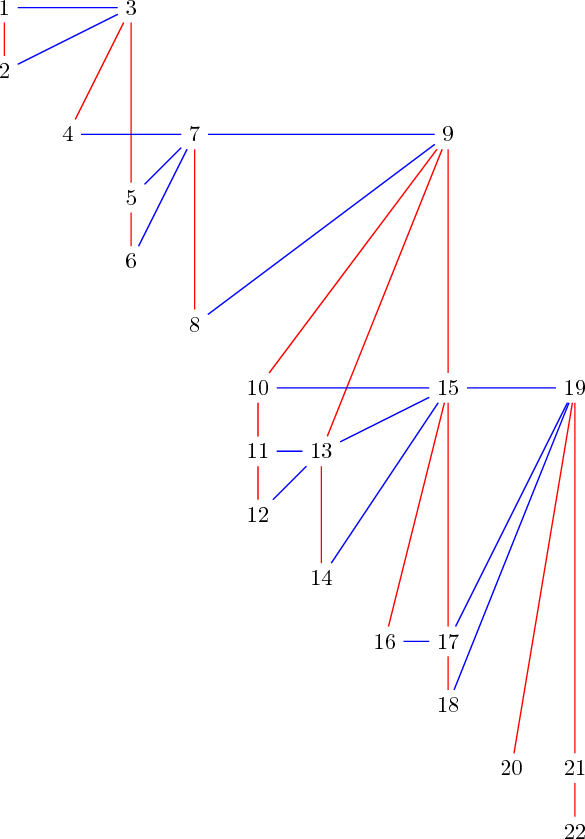

In [102]:
# the example of Fig. 30
p1 = (1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0)
p2 = (1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0)
inter = (p1, p2)
mtip = m_interval_to_m_interval_poset(2, inter)
viewLatex(mtip)

In [103]:
print m_interval_poset_to_m_interval(2,mtip)

((1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0))


In [104]:
# you can check Prop. 5.11
print m_rises_interval(inter)
print rises_interval(mtip) # x 2

1
2


In [105]:
print m_rise_vector_interval(inter)
print rise_vector_interval(mtip) # x 2

[1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0]
[2, 0, 4, 0, 0, 2, 0, 4, 0, 2, 0, 0, 2, 2, 0, 0, 4, 0, 0, 0, 0, 0]


In [106]:
print m_contacts_interval(2, inter)
print contacts_interval(mtip) # the same

5
5


In [107]:
print m_contact_vector_interval(2, inter)
print contact_vector_interval(mtip) # adds 1 to odd positions

[5, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[5, 1, 0, 2, 0, 1, 0, 1, 0, 3, 1, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1]


### expand - contract

In [108]:
def expand_grafting_tree(m, tree, k = 1):
    """
    Return the expanded grafting tree of a m-grafting tree
    INPUT:
    
        - m an integer 
        - tree a labelled binary tree (m-grafting tree)
        - k = 1, a internal recursive parameter
    """
    if tree.is_empty():
        return tree
    left = expand_grafting_tree(m, tree[0], k)
    k = k + left.node_number()
    right = expand_grafting_tree(m, tree[1], k+1)
    label = m*tree.label() if k%m == 0 else m*(tree.label() - 1)
    return LabelledBinaryTree([left, right], label = label)


def contract_grafting_tree(m, tree, k = 1):
    """
    Return the contracted grafting tree of a m-rise-contact divisible grafting tree
    INPUT:
    
        - m an integer 
        - tree a labelled binary tree (grafting tree)
        - k = 1, a internal recursive parameter
    """
    if tree.is_empty():
        return tree
    left = contract_grafting_tree(m, tree[0], k)
    k = k + left.node_number()
    right = contract_grafting_tree(m, tree[1], k+1)
    label = tree.label()/m if k%m == 0 else tree.label()/m + 1
    return LabelledBinaryTree([left, right], label = label)

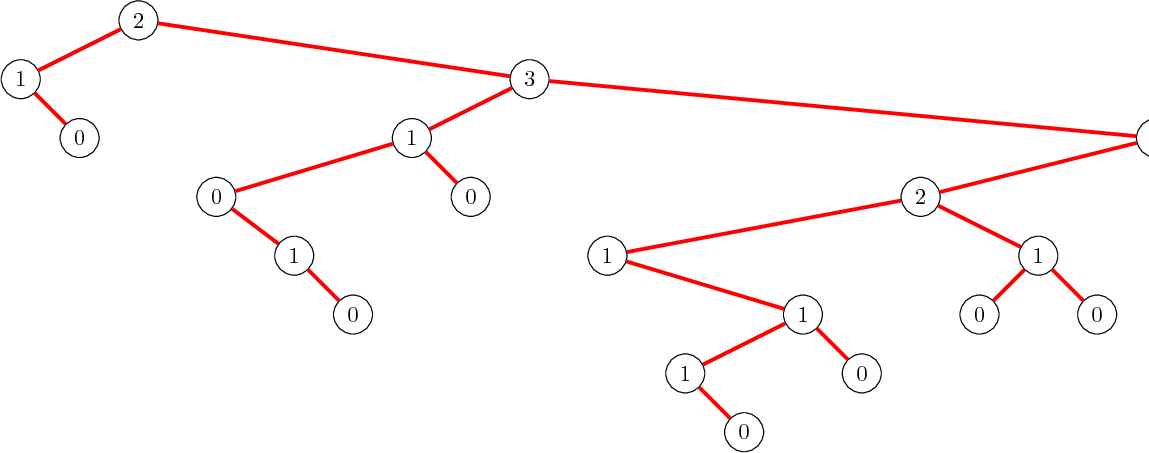

In [109]:
# The example of Fig. 30

mtree = grafting_tree(mtip)
tree_image = expand_grafting_tree(2,mtree)
viewLatex(mtree)

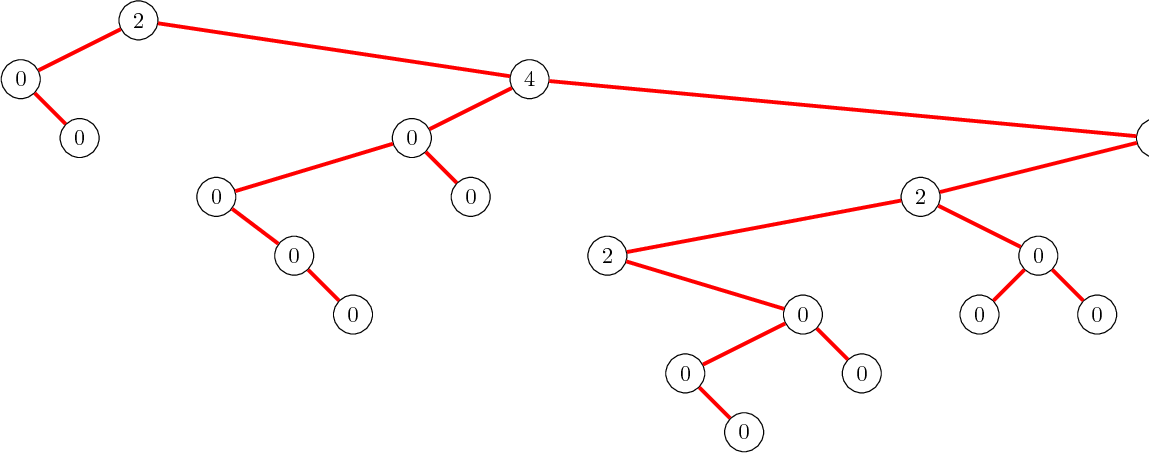

In [110]:
viewLatex(tree_image)

In [111]:
mtree == contract_grafting_tree(2,tree_image)

True

### The $m$-Rise-Contact involution

In [112]:
def m_rise_contact_involution(m, inter):
    """
    Return the result of the m-Rise-contact involutionon a m-interval
    
    INPUT:
    
        - `m` an integer
        - inter a tuple of m-paths
    """
    mtip = m_interval_to_m_interval_poset(m, inter)
    mtree = grafting_tree(mtip)
    mtip_image = interval_from_grafting_tree(contract_grafting_tree(m, rise_contact_involution_grafting_tree(expand_grafting_tree(m,mtree))))
    return m_interval_poset_to_m_interval(m, mtip_image)

In [113]:
# the example of Fig. 30
p1 = (1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0)
p2 = (1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0)
inter = (p1, p2)
print m_rise_contact_involution(2, inter)

((1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))


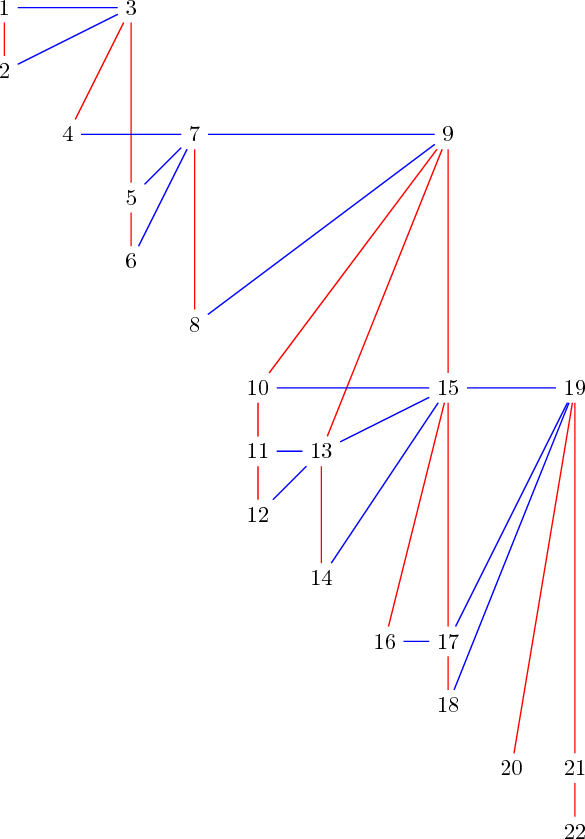

In [114]:
# Step by step
p1 = (1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0)
p2 = (1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0)
inter = (p1, p2)
# the m-interval poset
mtip = m_interval_to_m_interval_poset(2, inter)
viewLatex(mtip)

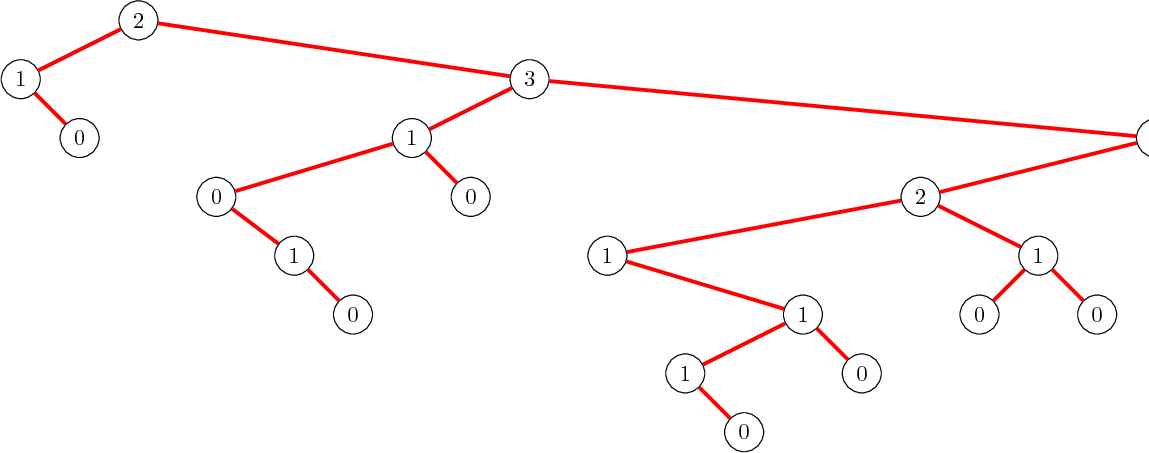

In [115]:
# the m-grafting tree
mtree = grafting_tree(mtip)
viewLatex(mtree)

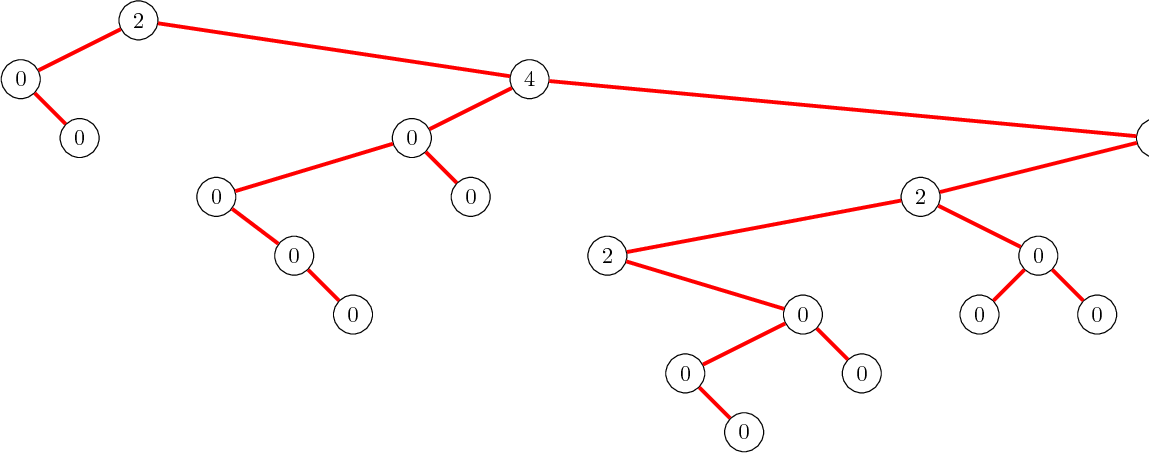

In [116]:
# the expanded tree
mtree_expanded = expand_grafting_tree(2, mtree)
viewLatex(mtree_expanded)

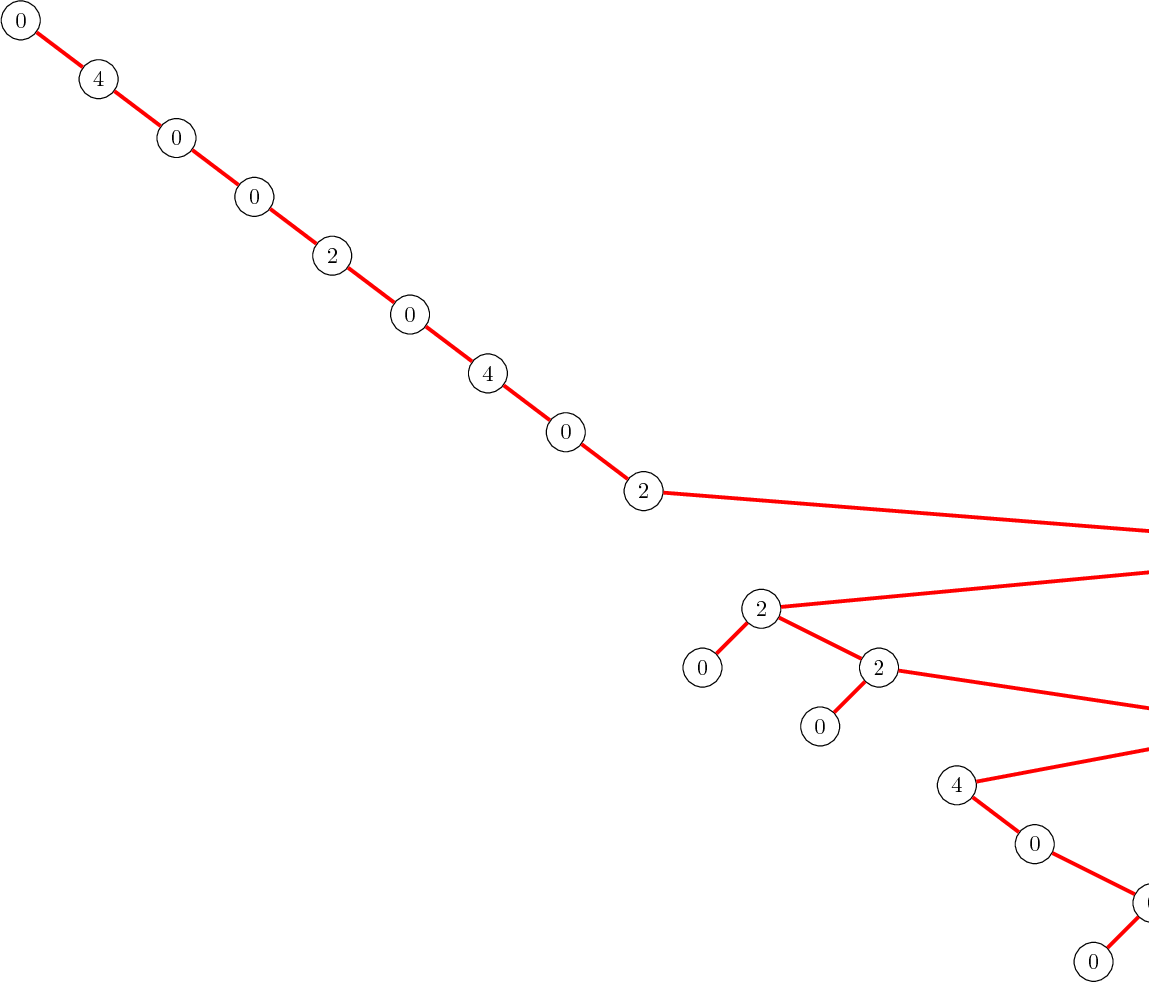

In [117]:
# the rise-contact involution (left-border + complement + left-border)
tree_image = rise_contact_involution_grafting_tree(mtree_expanded)
viewLatex(tree_image)

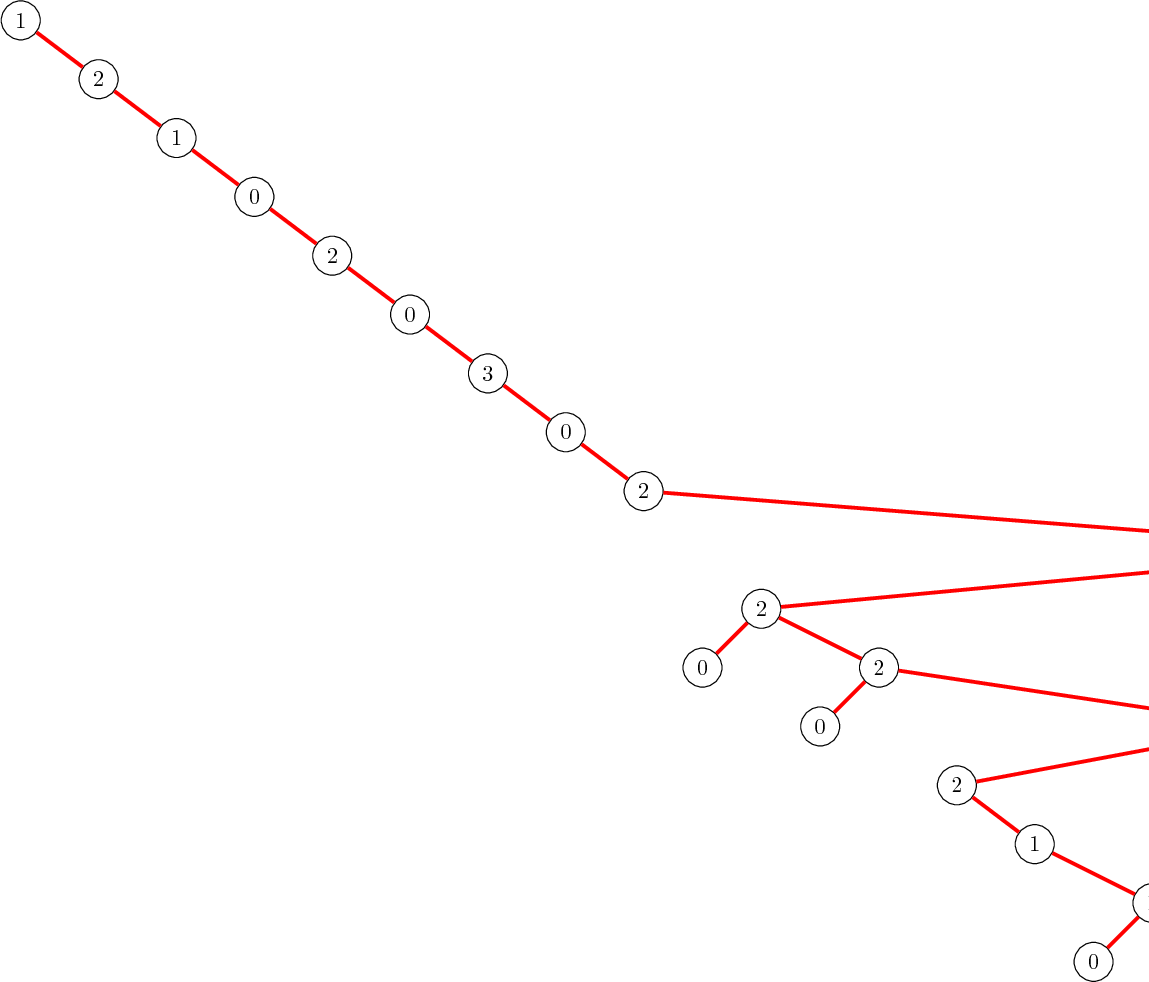

In [118]:
# we contract the result
tree_contracted = contract_grafting_tree(2,tree_image)
viewLatex(tree_contracted)

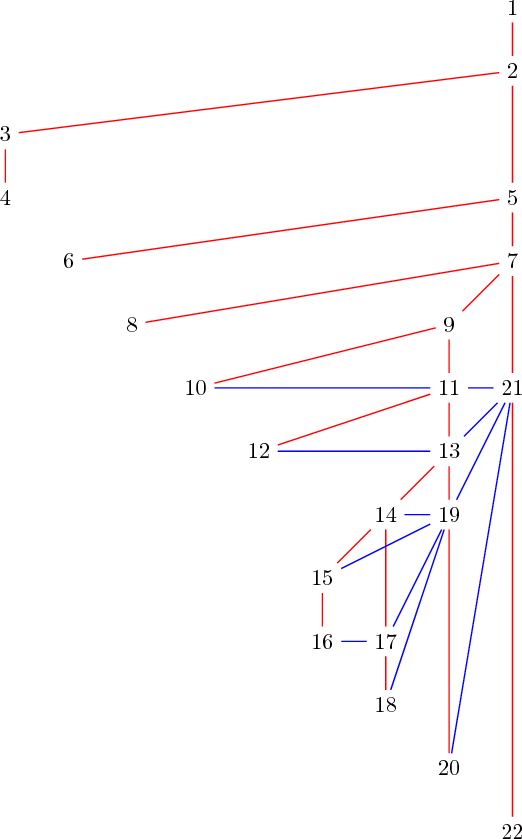

In [119]:
# the corresponding m-interval-poset
mtip_image = interval_from_grafting_tree(tree_contracted)
viewLatex(mtip_image)

In [120]:
# the corresponding interval (p1, p2)
print m_interval_poset_to_m_interval(2, mtip_image)

((1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))


We can check that the action on statistic is what we we want.

In [121]:
def check_m_rise_contact_statistics(m, inter):
    image = m_rise_contact_involution(m, inter)
    return m_contacts_interval(m, inter) == m_rises_interval(image) \
    and m_contact_monomial(m, inter) == m_rise_monomial(inter) \
    and m_distance(m, inter) ==  m_distance(m, image)

In [122]:
check_m_rise_contact_statistics(2, inter)

True

In [123]:
all(check_m_rise_contact_statistics(m,v) for m in xrange(2,4) for n in xrange(2,4) for v in m_intervals(m,n) )

True